El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3725128/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "dxDAO - xDXdao"
ORG_PLATFORM = "daostack"
SPLITS_FREQ = "5d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = None


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 8479 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8479 entries, 0 to 8478
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       8479 non-null   object        
 1   name           8479 non-null   object        
 2   id             8479 non-null   object        
 3   proposal       8479 non-null   category      
 4   deployment     8479 non-null   object        
 5   platform_vote  8479 non-null   object        
 6   voter          8479 non-null   category      
 7   date           8479 non-null   datetime64[ns]
 8   choice         8479 non-null   object        
 9   weight         8479 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 648.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2226 entries, 0 to 2225
Data columns (total 13 columns):
 #   Column               Non-Null Co

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501,c3e93130-1eca-5709-9e86-d6ac3a9c1cad,2023-03-14 02:47:23,1
1,0xabd238fa6b6042438fbd22e7d398199080b4224c,70ec51fe-7cbc-5fbe-8ebf-c886ace664ff,2022-05-22 02:09:49,1
2,0x13a0b42b9c180065510615972858bf41d1972a55,a501deb0-2016-565e-bd90-9421bc215682,2019-08-02 09:25:38,1
3,0xb0e83c2d71a991017e0116d58c5765abc57384af,370e8509-060d-547c-bd5b-f75f9427b033,2020-08-28 12:12:34,1
4,0x91628ddc3a6ff9b48a2f34fc315d243eb07a9501,bcf10de1-fb7d-5904-938e-c8942712d595,2023-03-26 15:16:47,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                          2218
mean      9 days 06:19:18.320108205
std      10 days 19:40:49.362318507
min                 0 days 00:50:10
25%          5 days 09:23:06.250000
50%                 6 days 17:47:15
75%          8 days 20:25:46.250000
max               190 days 22:23:20
dtype: object

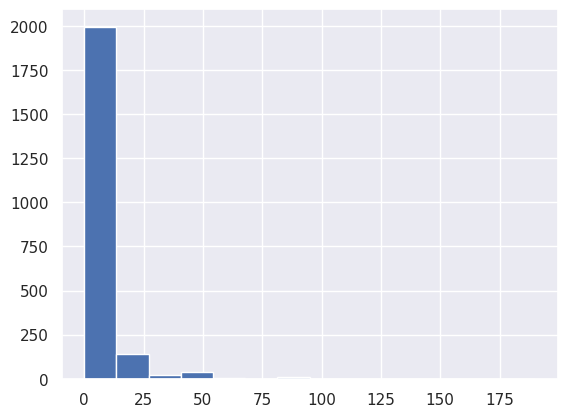

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

In [7]:
delta.value_counts()

30 days 00:00:25    7
8 days 00:03:12     2
5 days 04:19:20     2
5 days 03:20:40     2
8 days 00:02:55     2
                   ..
11 days 14:38:19    1
16 days 00:03:09    1
4 days 09:38:46     1
8 days 03:34:23     1
6 days 21:31:25     1
Length: 2181, dtype: int64

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

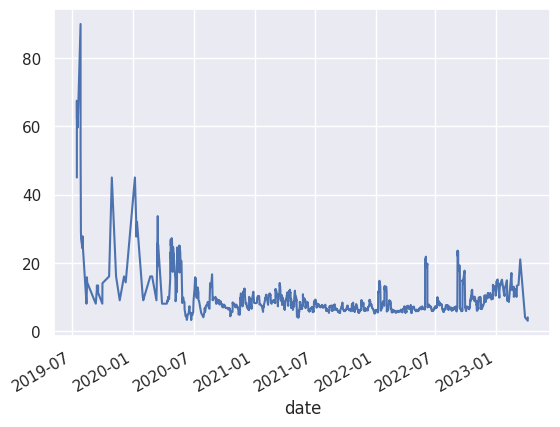

In [8]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Monday       422
Wednesday    386
Friday       371
Thursday     361
Tuesday      340
Sunday       182
Saturday     164
Name: start, dtype: int64

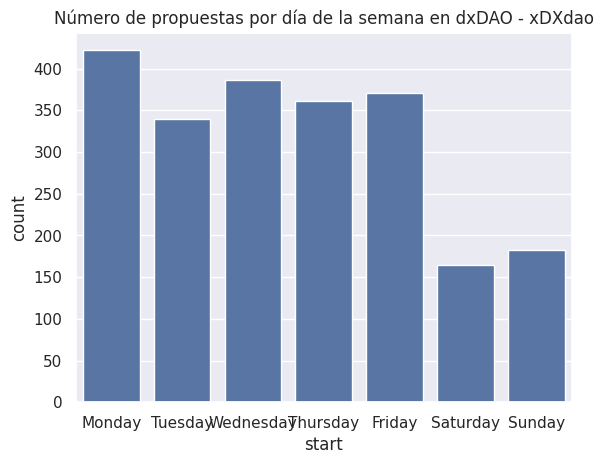

In [9]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Text(0, 0.5, '')

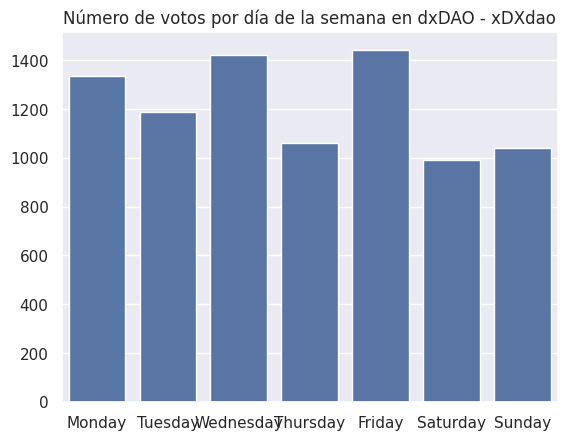

In [10]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()
plt.xlabel('')
plt.ylabel('')

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

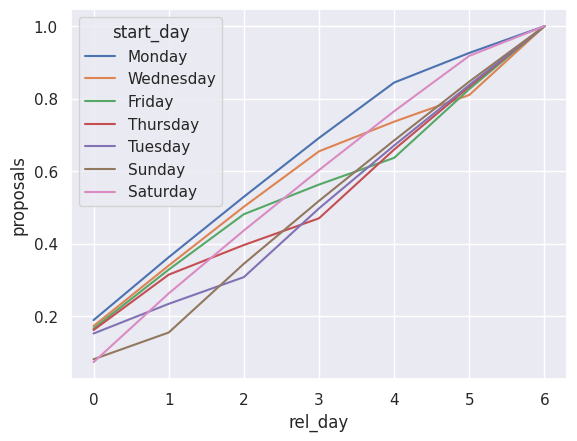

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

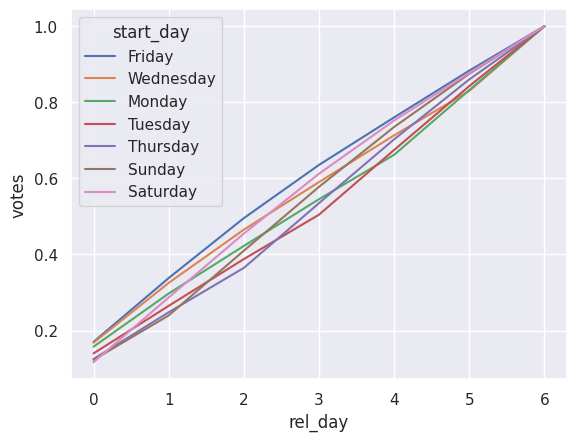

In [12]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

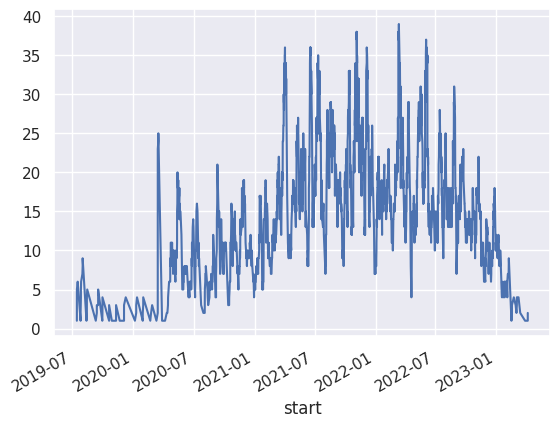

In [13]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [14]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                           W-SUN       W-MON       W-TUE  \
votes in open proposals (train) count  194.000000  194.000000  194.000000   
                                mean    30.443299   28.711340   28.139175   
                                std     23.755433   22.765740   23.707549   
                                min      0.000000    0.000000    0.000000   
                                50%     25.000000   23.000000   22.000000   
                                max    122.000000  120.000000  139.000000   
users in open proposals (train) count  194.000000  194.000000  194.000000   
                                mean    11.448454   10.835052   10.731959   
                                std      8.124671    7.622139    7.731257   
                                min      0.000000    0.000000    0.000000   
                                50%     10.000000    9.000000    9.000000   
                                max     44.000000   44.000000   44.000000   
open proposals                  count  194.000000  194.000000  194.000000   
                                mean    15.427835   14.608247   14.726804   
                                std      8.355287    7.792060    7.666129   
                                min      0.000000    0.000000    0.000000   
                                50%     15.000000   15.000000   15.000000   
                                max     42.000000   37.000000   34.000000   
votes in test                   count  194.000000  194.000000  194.000000   
                                mean    22.845361   21.077320   23.201031   
                                std     20.265257   17.179310   24.014801   
                                min      0.000000    0.000000    0.000000   
                                50%     17.500000   17.000000   18.500000   
                                max    110.000000   71.000000  239.000000   
users in test                   count  194.000000  194.000000  194.000000   
                                mean     7.994845    7.788660    8.278351   
                                std      5.776043    5.372322    6.106553   
                                min      0.000000    0.000000    0.000000   
                                50%      7.000000    7.000000    8.000000   
                                max     35.000000   36.000000   37.000000   
vpp test                        count  191.000000  192.000000  192.000000   
                                mean     1.413861    1.393541    1.505288   
                                std      0.927541    0.957640    1.317732   
                                min      0.000000    0.000000    0.000000   
                                50%      1.272727    1.236364    1.181818   
                                max      5.666667    6.857143   13.277778   
vpu test                        count  188.000000  189.000000  188.000000   
                                mean     2.686758    2.563545    2.601133   
                                std      1.395188    1.323455    1.260146   
                                min      1.000000    1.000000    1.000000   
                                50%      2.400000    2.200000    2.348485   
                                max     10.666667   10.000000    9.833333   

f                                           W-WED       W-THU       W-SAT  
votes in open proposals (train) count  194.000000  194.000000  194.000000  
                                mean    28.474227   29.123711   30.726804  
                                std     25.053763   23.575590   24.585530  
                                min      0.000000    0.000000    0.000000  
                                50%     23.000000   24.000000   24.500000  
                                max    165.000000  122.000000  123.000000  
users in open proposals (train) count  194.000000  194.000000  194.000000  
                                mean    10.804124   11.154639   11.695876  
    

In [15]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3725128/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),5906.000000,5570.000000,5459.000000,5524.000000,5650.000000,5961.000000
users in open proposals (train),2221.000000,2102.000000,2082.000000,2096.000000,2164.000000,2269.000000
open proposals,2993.000000,2834.000000,2857.000000,2875.000000,2924.000000,3083.000000
votes in test,4432.000000,4089.000000,4501.000000,4493.000000,4339.000000,4674.000000
users in test,1551.000000,1511.000000,1606.000000,1607.000000,1527.000000,1578.000000
vpp test,270.047423,267.559911,289.015201,286.424458,272.280818,270.951226
vpu test,505.110567,484.509937,489.013026,487.476420,497.266204,513.689277


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [16]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [17]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [18]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [19]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2019-11-14 18:28:17)  =====
Currently open proposals: 4
Train votes in open proposals:  13
Test votes in open proposals:    4

===== Training on fold 1 (t: 2020-03-17 15:25:23)  =====
Currently open proposals: 25
Train votes in open proposals:  47
Test votes in open proposals:   57



===== Training on fold 2 (t: 2020-07-20 18:36:42)  =====
Currently open proposals: 8
Train votes in open proposals:  15
Test votes in open proposals:    3

===== Training on fold 3 (t: 2020-11-20 00:39:58)  =====
Currently open proposals: 10
Train votes in open proposals:  11
Test votes in open proposals:   18



===== Training on fold 4 (t: 2021-03-25 21:09:40)  =====
Currently open proposals: 27
Train votes in open proposals:  27
Test votes in open proposals:   33

===== Training on fold 5 (t: 2021-07-28 01:24:30)  =====
Currently open proposals: 17
Train votes in open proposals:  33
Test votes in open proposals:   30



===== Training on fold 6 (t: 2021-11-28 13:44:10)  =====
Currently open proposals: 14
Train votes in open proposals:  21
Test votes in open proposals:   10



===== Training on fold 7 (t: 2022-04-01 12:55:40)  =====
Currently open proposals: 13
Train votes in open proposals:  30
Test votes in open proposals:   17

===== Training on fold 8 (t: 2022-08-03 20:09:05)  =====
Currently open proposals: 21
Train votes in open proposals:  56
Test votes in open proposals:   27



===== Training on fold 9 (t: 2022-12-06 00:45:55)  =====
Currently open proposals: 20
Train votes in open proposals:  35
Test votes in open proposals:   15



In [20]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.240766,0.342594,0.217986,0.424996,0.175028,0.365411,0.260363,0.519114,0.140388,0.380493,0.281359,0.566548,0.499408,0.305492
std,0.220377,0.246388,0.180950,0.271914,0.203209,0.239822,0.201020,0.301433,0.190054,0.246068,0.228286,0.313292,0.203396,0.219808
min,0.072727,0.072704,0.031602,0.083694,0.050000,0.079263,0.038198,0.093750,0.033333,0.087267,0.039062,0.093750,0.300000,0.150000
25%,0.109211,0.150986,0.075893,0.272024,0.060909,0.169968,0.086089,0.302083,0.053889,0.176895,0.093090,0.302083,0.350000,0.175000
50%,0.163333,0.309223,0.174289,0.403865,0.094298,0.358814,0.253325,0.550000,0.073684,0.371030,0.259818,0.585714,0.488312,0.271429
75%,0.267857,0.379482,0.312083,0.526316,0.189286,0.441022,0.312083,0.670162,0.128571,0.441022,0.312083,0.834117,0.553333,0.300000
max,0.800000,0.800000,0.625000,1.000000,0.720000,0.770042,0.625000,1.000000,0.666667,0.830228,0.702165,1.000000,1.000000,0.900000


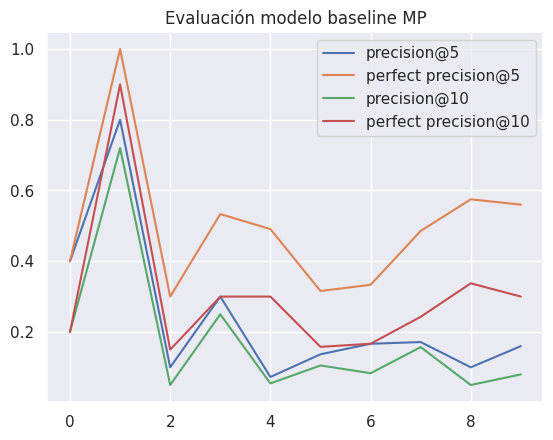

In [21]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,1.000000e+01,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.499408,1.000000e+00,0.930612,0.930612,0.305492,1.000000e+00,0.984232,0.984232,0.216995,1.000000e+00,0.997647,0.997647
std,0.203396,7.401487e-17,0.146632,0.146632,0.219808,7.401487e-17,0.049862,0.049862,0.187069,7.401487e-17,0.007441,0.007441
min,0.300000,1.000000e+00,0.521161,0.521161,0.150000,1.000000e+00,0.842322,0.842322,0.100000,1.000000e+00,0.976471,0.976471
25%,0.350000,1.000000e+00,0.938312,0.938312,0.175000,1.000000e+00,1.000000,1.000000,0.116667,1.000000e+00,1.000000,1.000000
50%,0.488312,1.000000e+00,0.983333,0.983333,0.271429,1.000000e+00,1.000000,1.000000,0.180952,1.000000e+00,1.000000,1.000000
75%,0.553333,1.000000e+00,1.000000,1.000000,0.300000,1.000000e+00,1.000000,1.000000,0.200000,1.000000e+00,1.000000,1.000000
max,1.000000,1.000000e+00,1.000000,1.000000,0.900000,1.000000e+00,1.000000,1.000000,0.733333,1.000000e+00,1.000000,1.000000


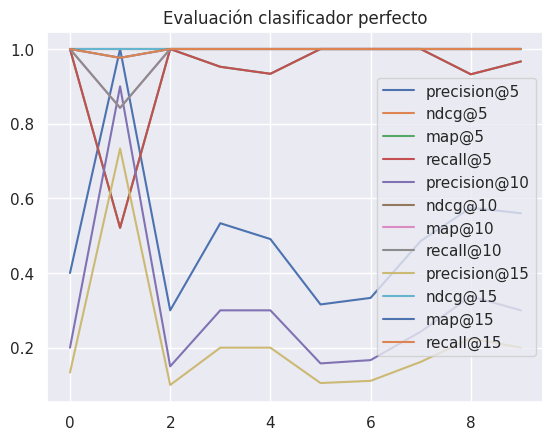

In [22]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [23]:
from tqdm.autonotebook import tqdm

In [24]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/272 [00:00<?, ?it/s]

Warning, empty test fold 17
Warning, empty test fold 18


Warning, empty test fold 31
Warning, empty test fold 32
Warning, empty test fold 33
Warning, empty test fold 34


Warning, empty test fold 52


Warning, empty test fold 91


Warning, empty test fold 270
Warning, empty test fold 271


In [25]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2019-07-14 19:50:09 2023-04-09 11:34:47


t0: 2019-07-19 00:00:00
t1: 2019-07-24 00:00:00
t-2: 2023-03-30 00:00:00
t-1: 2023-04-04 00:00:00


In [26]:
{ k:len(v) for k,v in metrics.items() }

{'t': 272,
 'precision@5': 272,
 'ndcg@5': 272,
 'map@5': 272,
 'recall@5': 272,
 'precision@10': 272,
 'ndcg@10': 272,
 'map@10': 272,
 'recall@10': 272,
 'precision@15': 272,
 'ndcg@15': 272,
 'map@15': 272,
 'recall@15': 272}

In [27]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2019-07-14 12:08:13')

Timestamp('2019-07-14 19:50:09')

,userID,itemID,timestamp,rating
1829,0x166cea845ade3f3b40ea68045d699dee5a645905,82f205b3-1f75-5da5-973a-fc2e324d8719,2019-07-14 19:50:09,1
396,0x166cea845ade3f3b40ea68045d699dee5a645905,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,2019-07-14 19:51:24,1
2421,0xe858a4bf603995a9156edbd25ff06269d997839e,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,2019-07-14 22:24:38,1
2287,0xe858a4bf603995a9156edbd25ff06269d997839e,398d685b-8c4f-5b7d-a7d6-86f1fc78efa4,2019-07-14 22:29:44,1
1811,0xe858a4bf603995a9156edbd25ff06269d997839e,cb124ba8-a044-5790-8da9-43129a92c1f5,2019-07-14 22:31:43,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
1046,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,402117ef-d822-5417-b935-a032c95298de,d3229595-ac4c-55bf-9808-386fc5603bd1,0x3038b8940eacc02a5555f039fd648dcfbc7d91d700c6...,0xf16294a979a027f297dace2f618cb57bc4bf5d16,2019-07-14 12:08:13,This is a test proposal,# Hello World\n\nThis is a test proposal. Plea...,2019-07-14 12:08:13,2019-08-28 18:08:52,3
1263,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,b1f193e6-cf73-5a7a-85f3-a84d95c08b97,d3229595-ac4c-55bf-9808-386fc5603bd1,0xae9a111f0089cf0b80ad77c38ea37bc8f77805011f54...,0x9efb62473e702ae623f5efb16a44436107fd87ef,2019-07-14 12:15:47,Add distributed computation tokens [RLC] and [...,"Run on Lots of Computers Token ($RLC, [0x607F4...",2019-07-14 12:15:47,2019-10-12 12:16:22,25
473,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,82f205b3-1f75-5da5-973a-fc2e324d8719,d3229595-ac4c-55bf-9808-386fc5603bd1,0x8de194855379635110cd6defce61938e404e0bede47b...,0x9efb62473e702ae623f5efb16a44436107fd87ef,2019-07-14 12:18:18,Add HoloToken [HOT] to whitelist,HoloToken [HOT] [0x6c6EE5e31d828De241282B9606C...,2019-07-14 12:18:18,2019-08-25 19:24:15,23
1020,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,cb124ba8-a044-5790-8da9-43129a92c1f5,d3229595-ac4c-55bf-9808-386fc5603bd1,0xd0ca0fa2986182606eb54047a7724cbe0aac19d91979...,0xa343618637bcecb12a723c9007360c305b0507c2,2019-07-14 14:07:23,Remove the locking Eth for Reputation Scheme,Although the locking of Eth and tokens was a g...,2019-07-14 14:07:23,2019-10-12 15:41:19,10
465,daostack,dxDAO - xDXdao,0x519b70055af55a007110b4ff99b0ea33071c720a,398d685b-8c4f-5b7d-a7d6-86f1fc78efa4,d3229595-ac4c-55bf-9808-386fc5603bd1,0xb92d2df99a47244c07a9d7ef73530c273f1d65230dbf...,0x0bba959486e1adde6027f078a82156d7a65f096e,2019-07-14 14:48:30,Give the power to me,I will make the dxDAO great again!,2019-07-14 14:48:30,2019-08-28 14:48:52,19


In [28]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,0.134744,0.236114,0.179278,0.290140,0.101077,0.278362,0.207996,0.405029,0.076223,0.292571,0.215149,0.447076,0.429285,0.239733,0.952425
std,0.129994,0.257554,0.236286,0.324442,0.087728,0.263374,0.242337,0.347319,0.066341,0.262518,0.241977,0.350139,0.185792,0.127400,0.205476
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033333,0.032417,0.011706,0.029915,0.037500,0.078914,0.034396,0.110878,0.026667,0.099895,0.044257,0.166667,0.300000,0.150000,1.000000
50%,0.100000,0.150182,0.086000,0.169959,0.087868,0.199830,0.117913,0.305005,0.066667,0.211283,0.125331,0.373413,0.437647,0.225000,1.000000
75%,0.200000,0.369209,0.221830,0.433193,0.150000,0.424287,0.290124,0.648284,0.106495,0.428551,0.315988,0.750000,0.551389,0.301786,1.000000
max,0.600000,1.000000,1.000000,1.000000,0.516667,1.000000,1.000000,1.000000,0.455556,1.000000,1.000000,1.000000,1.000000,0.816667,1.000000


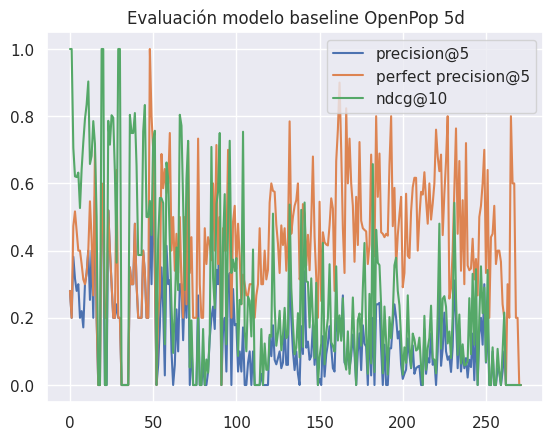

In [29]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [30]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,10.000000,10.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290000,0.145000,0.700000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.284605,0.142302,0.483046
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.025000,0.250000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.100000,1.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.525000,0.262500,1.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.400000,1.000000


,t,model,variable,value
0,2019-07-18 21:19:00,openpop,precision@5,0.280000
1,2019-07-23 22:00:12,openpop,precision@5,0.200000
2,2019-07-28 20:04:07,openpop,precision@5,0.381818
3,2019-08-02 13:41:33,openpop,precision@5,0.316667
4,2019-08-07 19:32:50,openpop,precision@5,0.280000
...,...,...,...,...
1083,2023-03-14 02:47:23,perfect,recall@5,1.000000
1084,2023-03-19 14:08:35,perfect,recall@5,1.000000
1085,2023-03-19 14:08:35,perfect,recall@5,1.000000
1086,2023-03-29 13:17:11,perfect,recall@5,0.000000


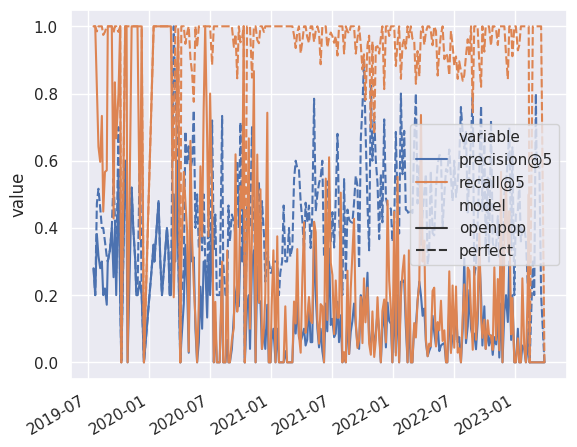

In [31]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [32]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2019-07-18 21:19:00,0.280000,1.000000,1.000000,1.000000,0.140000,1.000000,1.000000,1.000000,0.093333,1.000000,1.000000,1.0,openpop
1,2019-07-23 22:00:12,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.0,openpop
2,2019-07-28 20:04:07,0.381818,0.633092,0.520202,0.818182,0.245455,0.705501,0.590260,1.000000,0.163636,0.705501,0.590260,1.0,openpop
3,2019-08-02 13:41:33,0.316667,0.519113,0.424676,0.641667,0.233333,0.620907,0.504281,0.872222,0.172222,0.662699,0.526377,1.0,openpop
4,2019-08-07 19:32:50,0.280000,0.464757,0.360444,0.596667,0.230000,0.618862,0.464333,1.000000,0.153333,0.618862,0.464333,1.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2023-03-14 02:47:23,0.600000,1.000000,1.000000,1.000000,0.300000,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.0,perfect
268,2023-03-19 14:08:35,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.0,perfect
269,2023-03-19 14:08:35,0.200000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.0,perfect
270,2023-03-29 13:17:11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,perfect


Cannot show ipywidgets in text

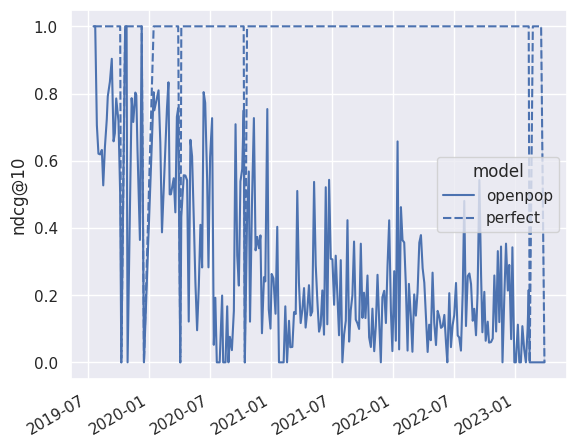

In [33]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [34]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.400000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000,0.133333,1.0,1.000000,1.000000
1,1.000000,1.0,0.521161,0.521161,0.900000,1.0,0.842322,0.842322,0.733333,1.0,0.976471,0.976471
2,0.300000,1.0,1.000000,1.000000,0.150000,1.0,1.000000,1.000000,0.100000,1.0,1.000000,1.000000
3,0.533333,1.0,0.952381,0.952381,0.300000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000
4,0.490909,1.0,0.933622,0.933622,0.300000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000
5,0.315789,1.0,1.000000,1.000000,0.157895,1.0,1.000000,1.000000,0.105263,1.0,1.000000,1.000000
6,0.333333,1.0,1.000000,1.000000,0.166667,1.0,1.000000,1.000000,0.111111,1.0,1.000000,1.000000
7,0.485714,1.0,1.000000,1.000000,0.242857,1.0,1.000000,1.000000,0.161905,1.0,1.000000,1.000000
8,0.575000,1.0,0.932292,0.932292,0.337500,1.0,1.000000,1.000000,0.225000,1.0,1.000000,1.000000
9,0.560000,1.0,0.966667,0.966667,0.300000,1.0,1.000000,1.000000,0.200000,1.0,1.000000,1.000000


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,0.429285,0.955882,0.923797,0.923797,0.239733,0.955882,0.952425,0.952425,0.162769,0.955882,0.955494,0.955494
std,0.185792,0.205735,0.207202,0.207202,0.127400,0.205735,0.205476,0.205476,0.091791,0.205735,0.205680,0.205680
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.300000,1.000000,0.943590,0.943590,0.150000,1.000000,1.000000,1.000000,0.100000,1.000000,1.000000,1.000000
50%,0.437647,1.000000,1.000000,1.000000,0.225000,1.000000,1.000000,1.000000,0.150000,1.000000,1.000000,1.000000
75%,0.551389,1.000000,1.000000,1.000000,0.301786,1.000000,1.000000,1.000000,0.204960,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.816667,1.000000,1.000000,1.000000,0.677778,1.000000,1.000000,1.000000


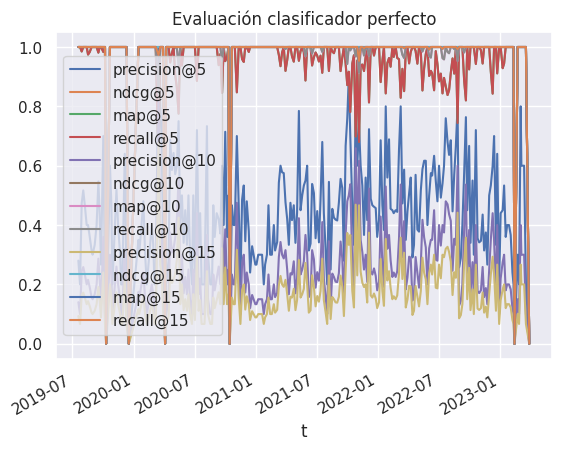

In [35]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [36]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 272 folds
From 2019-07-14 19:50:09 to 2023-04-09 11:34:47


,train,test,open,test users,test vpv,test vpp
count,272.000000,272.000000,272.000000,272.000000,262.000000,262.000000
mean,3716.172794,24.694853,15.261029,8.944853,0.479805,1.179755
std,2920.126594,24.485682,8.200996,6.753480,0.225617,1.140407
min,39.000000,0.000000,0.000000,0.000000,0.093750,0.250000
25%,1162.000000,8.000000,10.000000,4.000000,0.311164,0.666667
50%,2894.500000,19.000000,15.000000,8.000000,0.428571,0.925824
75%,6588.250000,36.000000,21.000000,12.000000,0.600000,1.272727
max,8441.000000,243.000000,43.000000,39.000000,1.000000,12.000000


In [37]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2019-07-19,39,51,6,34,0.666667,5.666667,2019-07-19 05:06:16,2019-10-04 15:14:21
1,2019-07-24,49,41,6,29,0.707317,4.833333,2019-07-25 10:17:39,2019-10-04 15:14:21
2,2019-07-29,85,76,12,31,0.407895,2.583333,2019-07-29 08:22:37,2019-10-04 15:15:13
3,2019-08-03,121,67,15,24,0.358209,1.714286,2019-08-03 19:11:52,2019-10-04 15:15:13
4,2019-08-08,132,56,14,21,0.375000,1.615385,2019-08-08 08:19:51,2019-10-04 15:15:13
...,...,...,...,...,...,...,...,...,...
267,2023-03-15,8437,3,7,1,0.333333,0.333333,2023-03-16 17:38:47,2023-03-26 15:16:47
268,2023-03-20,8439,1,3,1,1.000000,1.000000,2023-03-26 15:16:47,2023-03-26 15:16:47
269,2023-03-25,8439,1,2,1,1.000000,1.000000,2023-03-26 15:16:47,2023-03-26 15:16:47
270,2023-03-30,8441,0,2,0,NaN,NaN,NaT,NaT


In [38]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 205 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
241,2022-11-05,8166,27,22,15,0.555556,1.153846,2022-11-05 19:14:35,2022-11-23 18:46:11,True,True
242,2022-11-10,8201,44,20,17,0.386364,1.545455,2022-11-10 08:19:35,2022-11-23 18:46:11,True,True
243,2022-11-15,8232,26,12,15,0.576923,2.142857,2022-11-15 07:22:15,2022-11-23 18:46:11,True,True
244,2022-11-20,8248,30,15,16,0.533333,1.777778,2022-11-20 07:19:23,2022-11-25 14:46:11,True,True
245,2022-11-25,8278,6,11,4,0.666667,0.800000,2022-11-25 14:46:11,2022-11-30 16:24:11,True,True
246,2022-11-30,8285,12,12,4,0.333333,0.571429,2022-11-30 16:24:11,2022-12-11 15:30:59,True,True
247,2022-12-05,8293,21,18,6,0.285714,0.500000,2022-12-05 12:51:35,2022-12-20 08:35:11,True,True
248,2022-12-10,8304,22,18,5,0.227273,0.357143,2022-12-10 10:11:45,2022-12-20 08:35:11,True,True
249,2022-12-15,8324,7,18,2,0.285714,0.333333,2022-12-15 10:36:11,2022-12-20 08:35:11,True,True
250,2022-12-20,8333,10,16,6,0.600000,0.857143,2022-12-20 08:33:47,2022-12-26 12:34:59,True,True


In [39]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 82 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window


            train  test  i
t                         
2019-07-19     39    51  0
2019-07-24     49    41  1
2019-07-29     85    76  2
2019-08-03    121    67  3
2019-08-08    132    56  4
2019-08-13    165    29  5
2019-08-18    185    40  6
2019-08-23    201    24  7
2019-08-28    211    14  8
2019-09-02    212    13  9


Cannot show ipywidgets in text

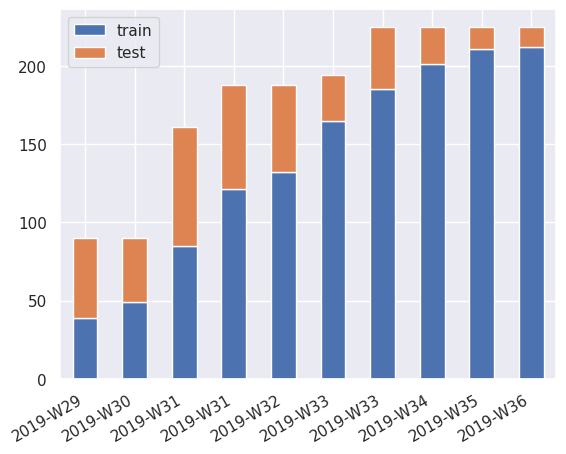

In [40]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

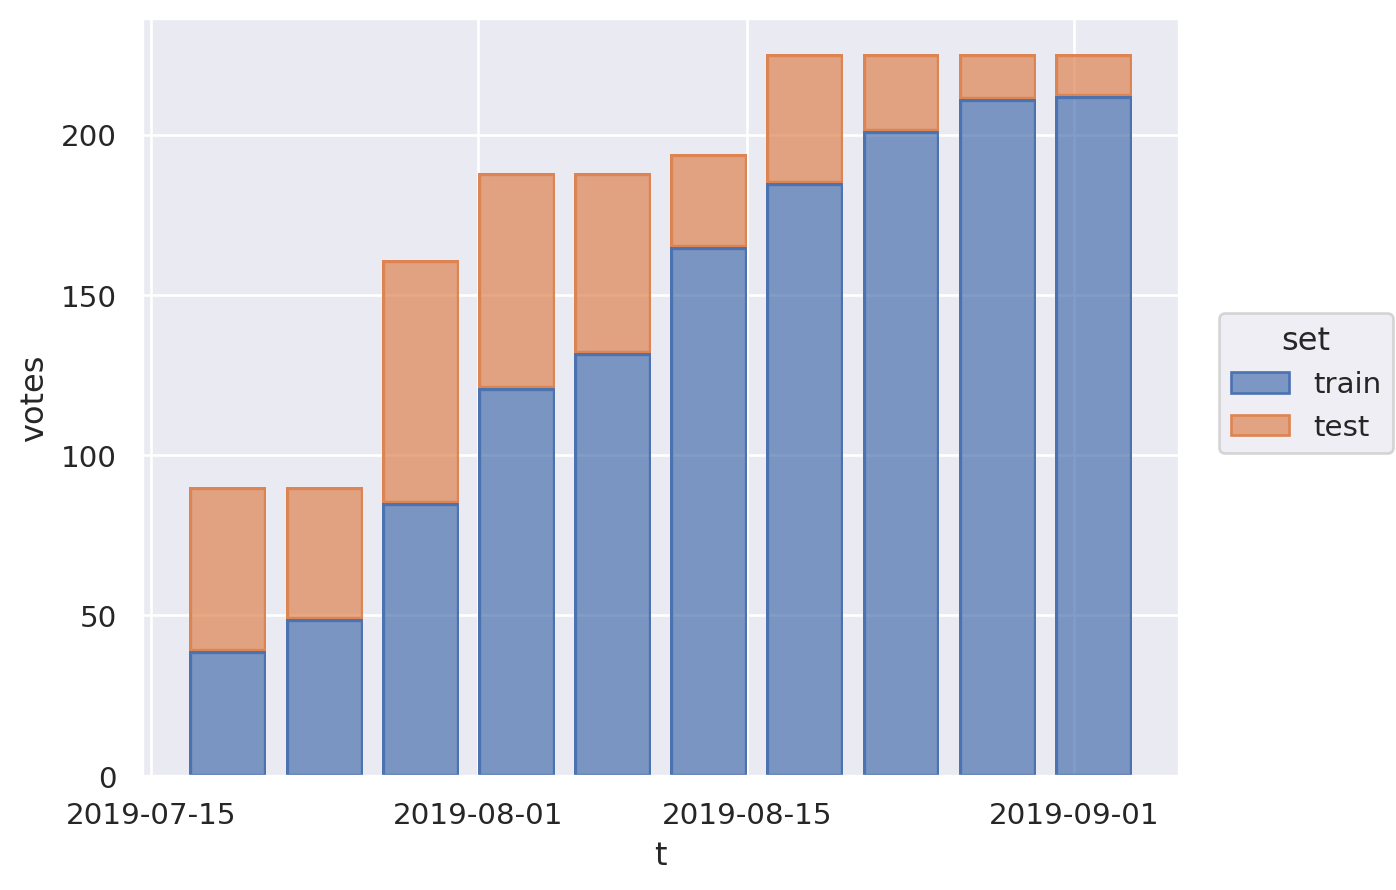

In [41]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())